Importing all the modules. Some may not be needed as of now. 

In [10]:
# modules - probably too many
import numpy as np
import pandas as pd
import pickle
import matplotlib
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn import neighbors
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.colors as colors
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'
import math
import seaborn as sns
import multiprocessing
import numpy.matlib as npm
import geeadd
import ee
#import mlLocal
from importlib import reload

In [ ]:
def trainClassifier(dataDict,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset,samplingFeatures=None,minSubSamples=2000,minSatSamples=-1,maxSamples=10000,percentilePairwiseDist=99,maxleafnodesParent= 1, minSamplesLeafParent=100, maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures="auto",nTrees = 100):
    
    
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDict.keys():
        print('biome:',biome)

        if ( biome <10):
            # subset only the regressors and response 
            dfBiome = dataDict[biome]['DF'][sum([regressorsNames,response],[])].astype('int')

            
            # resample the data for calibrating parent tree
            if ( samplingFeatures != None ) :
                dfParent = resampleDF(dfBiome ,regressorsNames,samplingFeatures,minSubSamples=minSubSamples,minSatSamples=minSatSamples,maxSamples=maxSamples,percentilePairwiseDist=percentilePairwiseDist)
                print('subsampled',dfParent.shape)

                dfParent = resampleDF(dfParent,regressorsName,features,minSubSamples,minSubSamples=minSubSamples,minSatSamples=minSatSamples,maxSamples=maxSamples,percentilePairwiseDist=50)
            else :
                dfParent = dfBiome
                
            dfBiome.columns = sum([regressors,response],[])
            dfParent.columns = sum([regressors,response],[])
            print(dfBiome.shape)
            print(dfParent.shape)
             # populate a parent RF dictionary that holds a single tree RF used to partition data into child RFs
            parentRFDict = {}
            parentRFDict.update({'regressors': regressors})
            parentRFDict.update({'regressorsGEE': regressorsGEENames})
            parentRFDict.update({'response': response})
            parentRFDict.update({'domain':makeDomain(dfBiome[regressors],domainIndex,domainScaling,domainOffset)})
            parentRFDict.update({'RF': RandomForestRegressor(n_estimators=1,min_samples_leaf=minSamplesLeafParent,min_samples_split=int(dfParent.shape[0]*0.1),bootstrap=False,random_state=0,verbose=0,max_depth=10,max_leaf_nodes=maxleafnodesParent,max_features=maxFeatures,n_jobs=40) \
                                                                                                         .fit(dfParent[regressors], np.array(dfParent[response]).ravel())})       
            
            # label input data using the prediction from the parent RF as this will be unique
            dfBiome['estimate']=np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)

            # populate dictionary of children RFs, each childRF is itself a dictionary similar to the parentRF but now using more than one tree
            # each child is labelled using the prediction value from the parentRF corresponding to its partition
            childrenRFDict = {}
            print('number children:',np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)).size)
            for partition in np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)):
                dfpartitionBiome = dfBiome.loc[dfBiome['estimate'] == partition]
                childRFDict = {}
                childRFDict.update({'size': dfpartitionBiome[response].shape[0]})
                childRFDict.update({'regressors': regressors})
                childRFDict.update({'regressorsGEE': regressorsGEENames})
                childRFDict.update({'response': response})
                childRFDict.update({'domain':makeDomain(dfpartitionBiome[regressors],domainIndex,domainScaling,domainOffset)})
                childRFDict.update({'RF': RandomForestRegressor(n_estimators=nTrees,min_samples_leaf=minSamplesLeafChild,bootstrap=True,random_state=0,verbose=0,max_depth=9,max_leaf_nodes=maxleafnodesChild,max_features=maxFeatures,n_jobs=40) \
                                         .fit(dfpartitionBiome[regressors], np.array(dfpartitionBiome[response]).ravel())})             
                childrenRFDict.update({partition: childRFDict})

            # assign the childrenRFDict to the parent
            parentRFDict.update({'childrenRFDict':childrenRFDict })      

            #assign the parentRF dict to the calibration data dictionary for trhis biome
            dataDict[biome].update({method+response[0]+'parentRFDict':parentRFDict})   
    return dataDict

In [ ]:
# apply algorithm to data 
def predictClassifier(dataDict,methodDict, method, regressorsNames, response):
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDict.keys():
        print('biome:',biome)

        if ( biome <9):
            # subset only the regressors 
            dfBiome = dataDict[biome]['DF'][sum([regressorsNames],[])].astype('int')
            dfBiome.columns = regressors

            #apply the parent classifier
            parentRF = methodDict[biome][method+response[0]+'parentRFDict']['RF']
            dfBiome['childNames'] =  np.around(parentRF.predict(dfBiome),decimals=3)
            dataDict[biome]['DF'][method + response[0]+'childNames'] =dfBiome['childNames']

            for partition in np.unique(dfBiome['childNames'] ):
                dfBiome.loc[dfBiome['childNames']==partition,method + response[0]] = methodDict[biome][method+response[0]+'parentRFDict']['childrenRFDict'][partition]['RF'].predict(dfBiome.loc[dfBiome['childNames']==partition][regressors])  
            dataDict[biome]['DF'][method + response[0]] = dfBiome[method + response[0]]
           
    return dataDict

In [ ]:
def hierarchicalRF(dataDictParent,dataDictChild,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=20, minSamplesSplit=11,maxleafnodesParent= 100, minSamplesLeafParent=10, maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures="auto",nTrees = 100):
    
    
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDictParent.keys():
        print('biome:',biome)

        # subset only the regressors and response 
        dfBiome = dataDictChild[biome]['DF'][sum([regressorsNames,response],[])].astype('int')   
        dfParent = dataDictParent[biome]['DF'][sum([regressorsNames,response],[])].astype('int')


        dfBiome.columns = sum([regressors,response],[])
        dfParent.columns = sum([regressors,response],[])
        print('Total size ',dfBiome.shape)
        print('Parent size ',dfParent.shape)
         # populate a parent RF dictionary that holds a single tree RF used to partition data into child RFs
        parentRFDict = {}
        parentRFDict.update({'regressors': regressors})
        parentRFDict.update({'regressorsGEE': regressorsGEENames})
        parentRFDict.update({'response': response})
        parentRFDict.update({'domain':makeDomain(dfBiome[regressors],domainIndex,domainScaling,domainOffset)})
        parentRFDict.update({'RF': RandomForestRegressor(n_estimators=1,min_samples_leaf=minSamplesLeafParent,min_samples_split=minSamplesSplit,bootstrap=False,random_state=0,verbose=0,max_depth=maxDepth,max_leaf_nodes=maxleafnodesParent,max_features=maxFeatures,n_jobs=40) \
                                                                                                         .fit(dfParent[regressors], np.array(dfParent[response]).ravel())})         
        # label input data using the prediction from the parent RF as this will be unique
        dfBiome['estimate']=np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)

        # populate dictionary of children RFs, each childRF is itself a dictionary similar to the parentRF but now using more than one tree
        # each child is labelled using the prediction value from the parentRF corresponding to its partition
        childrenRFDict = {}
        print('number children:',np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)).size)
        for partition in np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)):
            dfpartitionBiome = dfBiome.loc[dfBiome['estimate'] == partition]
            childRFDict = {}
            childRFDict.update({'size': dfpartitionBiome[response].shape[0]})
            childRFDict.update({'regressors': regressors})
            childRFDict.update({'regressorsGEE': regressorsGEENames})
            childRFDict.update({'response': response})
            childRFDict.update({'domain':makeDomain(dfpartitionBiome[regressors],domainIndex,domainScaling,domainOffset)})
            childRFDict.update({'RF': RandomForestRegressor(n_estimators=nTrees,min_samples_leaf=minSamplesLeafChild,bootstrap=True,random_state=0,verbose=0,max_depth=9,max_leaf_nodes=maxleafnodesChild,max_features=maxFeatures,n_jobs=40) \
                                     .fit(dfpartitionBiome[regressors], np.array(dfpartitionBiome[response]).ravel())})             
            childrenRFDict.update({partition: childRFDict})

        # assign the childrenRFDict to the parent
        parentRFDict.update({'childrenRFDict':childrenRFDict })      

        #assign the parentRF dict to the calibration data dictionary for trhis biome
        dataDictParent[biome].update({method+response[0]+'parentRFDict':parentRFDict})   
    return dataDictParent

In [ ]:
# histogram plot of values and density for LAI and fAPAR for a biome and save to file

def histplotKDE(biome,outputFileName=None) :
    sns.set_context("paper")
    df1 = calbiomeDictLAI[biome]['DF'][['LAI','kde']].sample(np.min([1000,calbiomeDictLAI[biome]['DF'].shape[0]])).divide([10.,1.])
    df2 = valbiomeDictLAI[biome]['DF'][['LAI','kde']].sample(np.min([1000,valbiomeDictLAI[biome]['DF'].shape[0]])).divide([10.,1.])
    df3 = calbiomeDictFAPAR[biome]['DF'][['FAPAR','kde']].sample(np.min([1000,calbiomeDictFAPAR[biome]['DF'].shape[0]])).divide([10.,1.])
    df4 = valbiomeDictFAPAR[biome]['DF'][['FAPAR','kde']].sample(np.min([1000,valbiomeDictFAPAR[biome]['DF'].shape[0]])).divide([10.,1.])

    fig, axs = plt.subplots(ncols=2,nrows=2 , figsize=(7, 4))
    fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
    ax = axs[0,0]
    hb = sns.histplot(df1,x='LAI',ax=ax, fill=False, element="step",stat='probability')
    hb = sns.histplot(df2,x='LAI',ax=ax, fill=False, element="step",stat='probability')
    ax = axs[0,1]
    hb = sns.histplot(df1,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    hb = sns.histplot(df2,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    ax = axs[1,0]
    hb = sns.histplot(df3,x='FAPAR',ax=ax, fill=False, element="step",stat='probability')
    hb = sns.histplot(df4,x='FAPAR',ax=ax, fill=False, element="step",stat='probability')
    ax = axs[1,1]
    hb = sns.histplot(df3,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    hb = sns.histplot(df4,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    plt.show()
    if (outputFileName != None):
        fig.savefig(outputFileName, bbox_inches='tight') 
    return

In [ ]:
# does pair plots of densities for each method for a biome
def pairplotKDE(biome,outputFileName=None):
    df1 = calbiomeDictLAI[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAI[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df2 = calbiomeDictLAIFTL[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAIFTL[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df3 = calbiomeDictLAIKANG[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAIKANG[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df4 = calbiomeDictLAIFTLX2[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAIFTLX2[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
 
    hue1 = df1['kde'].divide(df1['kde'].median())
    hue2 = df2['kde'].divide(df2['kde'].median())
    hue3 = df3['kde'].divide(df3['kde'].median())
    hue4 = df4['kde'].divide(df2['kde'].median())

    # hue123 = np.array(pd.DataFrame([hue1,hue2,hue3,hue4]))
    hueNorm = (0,2) # (np.percentile(hue123,0.05),np.percentile(hue123,95))
    
    fig, axs = plt.subplots(ncols=4,nrows=2 , figsize=(12, 8),sharey='row',sharex= 'row')
    fig.subplots_adjust(hspace=0.2, left=0.07, right=0.93)
    ax =  axs[0,0]
    hb = sns.scatterplot(x=df1['LAI'],y=df1['FAPAR'],hue=df1['kde'].divide(df1['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[0,1]
    hb = sns.scatterplot(x=df2['LAI'],y=df2['FAPAR'],hue=df2['kde'].divide(df2['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[0,2]
    hb = sns.scatterplot(x=df3['LAI'],y=df3['FAPAR'],hue=df3['kde'].divide(df3['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[0,3]
    hb = sns.scatterplot(x=df4['LAI'],y=df4['FAPAR'],hue=df4['kde'].divide(df4['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,0]
    hb = sns.scatterplot(x=df1['red'],y=df1['NIR'],hue=df1['kde'].divide(df1['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,1]
    hb = sns.scatterplot(x=df2['red'],y=df2['NIR'],hue=df2['kde'].divide(df2['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,2]
    hb = sns.scatterplot(x=df3['red'],y=df3['NIR'],hue=df3['kde'].divide(df3['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,3]
    hb = sns.scatterplot(x=df4['red'],y=df4['NIR'],hue=df4['kde'].divide(df4['kde'].median()),hue_norm=hueNorm,ax=ax)
    if ( outputFileName != None ) :
        fig.savefig(outputFileName, bbox_inches='tight') 
    return

In [ ]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResultsCond(df,xname,yname,datarange,nbins,gamma):
    fig, ax0 = plt.subplots(figsize=(8,8))    
    predictions = np.array(df[xname])
    targets = np.array(df[yname])    
    print(np.sqrt(np.mean((predictions-targets)**2)))
    condHist = (np.histogram2d(targets,predictions, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax0.plot(x, 0*y, color="white", linewidth=1)
    f1=ax0.imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma=gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax0,fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax0.plot(xvalues, res ,'w.', label='Mean Value') 
    # unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    # ax0.plot(xvalues, unc ,'r.', label='Uncertainty')  
    ax0.plot(datarange[0],datarange[1],"w",label='1:1 Line')

In [ ]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResidualsCond(df,xname,yname,datarange,nbins,gamma):
    fig, ax0 = plt.subplots(figsize=(8,8))

    
    predictions = np.array(df[xname])
    targets = np.array(df[yname])
    condHist = (np.histogram2d(targets,predictions-targets, bins=nbins, range=datarange, normed=None, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0001)
    ax0.plot(x, 0*y, color="white", linewidth=1)
    f1=ax0.imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma=gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax0,fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax0.plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax0.plot(xvalues, unc ,'r.', label='Uncertainty')  
    # pre = np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)) - np.matlib.repmat(np.flipud(res),dataHist.shape[1],1)
    # ax0.plot(xvalues, pre ,'y.', label='Uncertainty')  

In [ ]:
# parse a sckitlearn decision tree into a R text tree suitable for use in GEE
# for compactness ancillary items like node sample size and residuals are forced to = 1
# this is a blind guess by Richard but seems to work
def make_tree(rf,regressors,decimals):
    
    # first get the output in sckitlearn text format in a dataframe
    r = export_text(rf,feature_names=regressors,show_weights=True,decimals=decimals)
    r = r.splitlines()
    rdf = pd.DataFrame(r,columns = ['rule'])

    #identify rules and not leaf values
    isrule = ~rdf['rule'].str.contains('value')
    rulesdf = rdf.loc[isrule]

    #determine level in tree and the associated starting based node number
    rdf['level'] = rdf['rule'].str.count(r'(\|)').values.tolist()
    rdf.loc[isrule,'base'] = ((rdf.level).mul(0).add(2)).pow(rdf.level)

    # get the actual tested condition
    rdf.loc[isrule,'condition'] =  rdf.loc[isrule,'rule'].str.extract(r'(x.+)').values.tolist()
    
    # identify leaf nodes and fill in the response value
    rdf.loc[~isrule,'leaf'] = '*'
    rdf['leaf'] = rdf['leaf'].fillna(method='bfill',limit=1)
    rdf.loc[~isrule,'response'] = rdf.loc[~isrule,'rule'].str.extract(r'([+-]?([0-9]*[.])?[0-9]+)')[0].values.tolist()
    rdf['response'] = rdf['response'].fillna(method='bfill')

    #discard non rules
    rdf.loc[rdf['leaf'].isna(),'leaf'] = ' '
    rdf = rdf.dropna()

    #dtermine if this is a left or right branch
    rdf['branch'] = rdf['rule'].str.contains(r'(?:\>)').astype('int')
    rdf['node'] = rdf.base + rdf.branch
    rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
    rdfindex = rdf.index

    #asign a node number, this is non trivial and critical for use later
    #read https://www.r-bloggers.com/2022/10/understanding-leaf-node-numbers-when-using-rpart-and-rpart-rules/
    for row in range(2,rdf.shape[0]):
        # find the nearest row above
        df = rdf[0:row]
        if ( (rdf[row:row+1].level.values)[0] > 1 ):
            parentdf = df.loc[df.level == (rdf[row:row+1].level.values-1)[0]].iloc[-1]
            rdf.at[rdfindex[row],'parentbase'] = parentdf.base  
            rdf.at[rdfindex[row],'parentnode'] = parentdf.node  
            rdf.at[rdfindex[row],'node'] = rdf.iloc[row].node + 2 * (  parentdf.node - parentdf.base ) 
            
    # glue together each rule in a big string, add the root node and return as a list
    rdf['phrase'] = rdf.apply(lambda x:  ' ' *(2 * x.level) + str(int(x.node)) + ') ' + x.condition + ' 0 0 ' + str(x.response) + ' ' +x.leaf + '\n', axis=1)
    return ( '1) root 1 1 1 (1)\n'+''.join(rdf['phrase'].values.tolist()))

Reading in all calibration data.

In [3]:
dfALL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATall.pkl')
dfALLtrim = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrim.pkl')
dfALLtrimKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrimKANG.pkl')

Maps of Sample for each dataset

C:\Users\rfernand\AppData\Local\Temp\ipykernel_28704\743807554.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


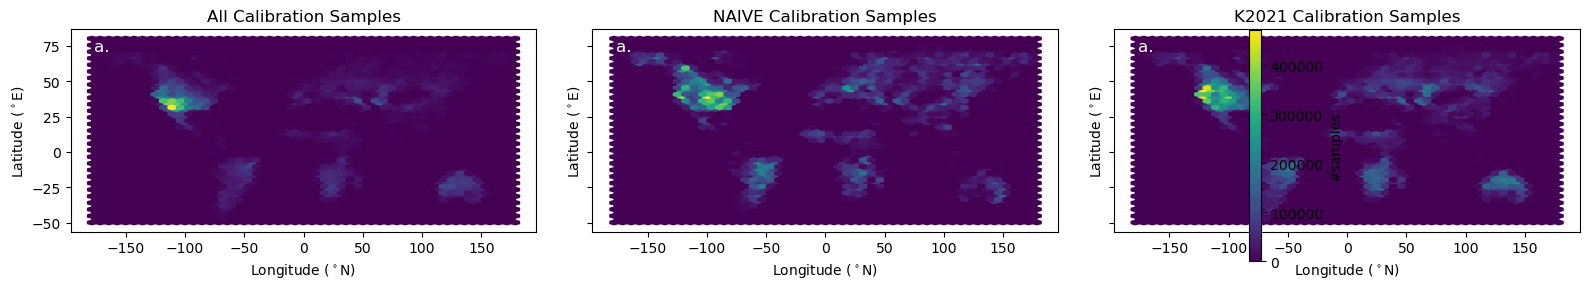

In [6]:
# RF - can you make this a bit more square and fix colorbar position
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,3), sharex=True, sharey=True)
cmap=cm.get_cmap('viridis')
hb = ax[0].hexbin(dfALL['Lon'],dfALL['Lat'], gridsize=(50),cmap=cmap)
hb = ax[1].hexbin(dfALLtrim['Lon'],dfALLtrim['Lat'], gridsize=(50),cmap=cmap)
hb = ax[2].hexbin(dfALLtrimKANG['Lon'], dfALLtrimKANG['Lat'], gridsize=(50),cmap=cmap)
ax[0].set_title("All Calibration Samples")
ax[0].set_ylabel("Latitude ($^\circ$N)")
ax[0].set_xlabel("Longitude ($^\circ$N)")
ax[0].text(0.05, 0.95, 'a.', transform=ax[0].transAxes, fontsize=12,verticalalignment='top',color='w')

ax[1].set_title("NAIVE Calibration Samples")
ax[1].set_ylabel("Latitude ($^\circ$N)")
ax[1].set_xlabel("Longitude ($^\circ$E)")
ax[1].text(0.05, 0.95, 'a.', transform=ax[1].transAxes, fontsize=12,verticalalignment='top',color='w')

ax[2].set_title("K2021 Calibration Samples")
ax[2].set_ylabel("Latitude ($^\circ$N)")
ax[2].set_xlabel("Longitude ($^\circ$E)")
ax[2].text(0.05, 0.95, 'a.', transform=ax[2].transAxes, fontsize=12,verticalalignment='top',color='w')

cb = fig.colorbar(hb, ax=ax)
cb.set_label('#samples')
plt.tight_layout()
#plt.savefig('Figure1.png', bbox_inches='tight')
plt.show()


In [7]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictFAPAR.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAI.pkl')
calbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPAR.pkl')

# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANG.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANG.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

Maps of Sample for each LC_Type

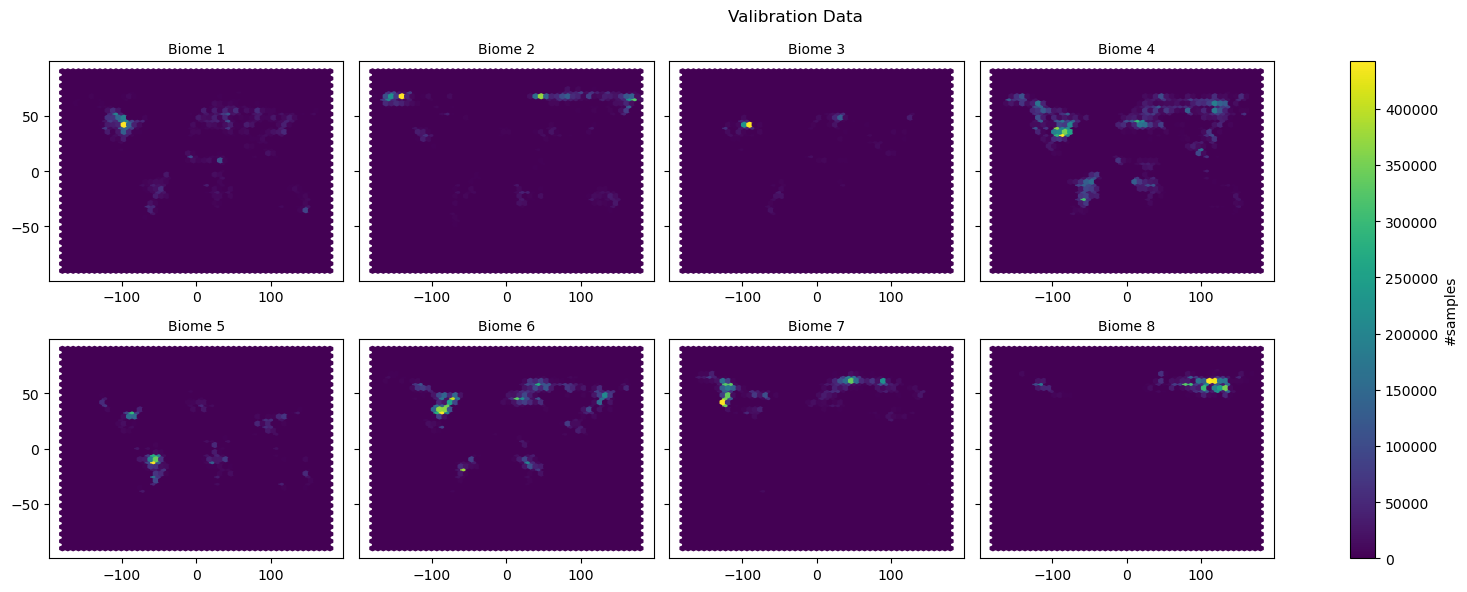

In [5]:
# RF - we will probably not put this in the paper but it is good to see the samples are in the expected area geographically
fig, axes = plt.subplots(2, 4, figsize=(16,6), sharey=True)
cmap=cm.get_cmap('viridis')
im=cm.ScalarMappable()
axes[0][0].hexbin(valbiomeDictLAI[1]['DF']['Lon'], valbiomeDictLAI[1]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][1].hexbin(valbiomeDictLAI[2]['DF']['Lon'], valbiomeDictLAI[2]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][2].hexbin(valbiomeDictLAI[3]['DF']['Lon'], valbiomeDictLAI[3]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][3].hexbin(valbiomeDictLAI[4]['DF']['Lon'], valbiomeDictLAI[4]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

axes[1][0].hexbin(valbiomeDictLAI[5]['DF']['Lon'], valbiomeDictLAI[5]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][1].hexbin(valbiomeDictLAI[6]['DF']['Lon'], valbiomeDictLAI[6]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][2].hexbin(valbiomeDictLAI[7]['DF']['Lon'], valbiomeDictLAI[7]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][3].hexbin(valbiomeDictLAI[8]['DF']['Lon'], valbiomeDictLAI[8]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

fig.suptitle('Valibration Data')

# Title biomes
axes[0][0].set_title('Biome 1', size=10)
axes[0][1].set_title('Biome 2', size=10)
axes[0][2].set_title('Biome 3', size=10)
axes[0][3].set_title('Biome 4', size=10)

axes[1][0].set_title('Biome 5', size=10)
axes[1][1].set_title('Biome 6', size=10)
axes[1][2].set_title('Biome 7', size=10)
axes[1][3].set_title('Biome 8', size=10)

fig.tight_layout()

#Add colorbar
cb = fig.colorbar(hb, ax=axes)
cb.set_label('#samples')

plt.show()

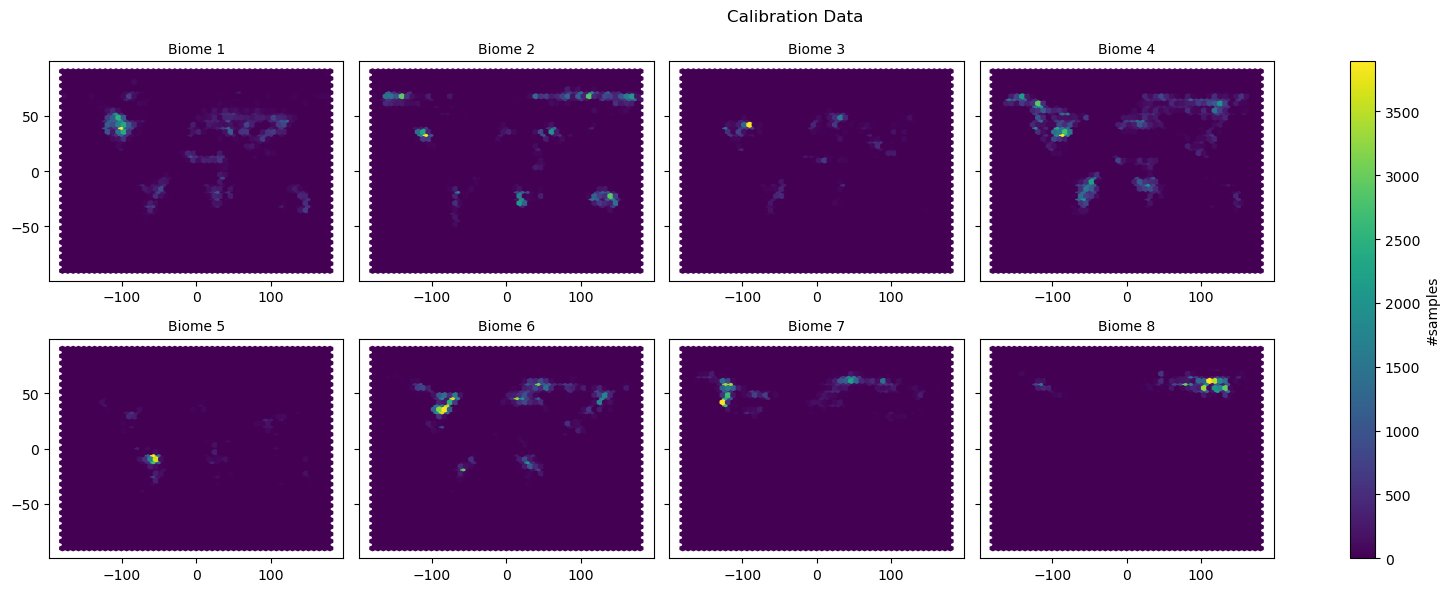

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(16,6), sharey=True)
cmap=cm.get_cmap('viridis')
im=cm.ScalarMappable()
axes[0][0].hexbin(calbiomeDictLAI[1]['DF']['Lon'], calbiomeDictLAI[1]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][1].hexbin(calbiomeDictLAI[2]['DF']['Lon'], calbiomeDictLAI[2]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][2].hexbin(calbiomeDictLAI[3]['DF']['Lon'], calbiomeDictLAI[3]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][3].hexbin(calbiomeDictLAI[4]['DF']['Lon'], calbiomeDictLAI[4]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

axes[1][0].hexbin(calbiomeDictLAI[5]['DF']['Lon'], calbiomeDictLAI[5]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][1].hexbin(calbiomeDictLAI[6]['DF']['Lon'], calbiomeDictLAI[6]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][2].hexbin(calbiomeDictLAI[7]['DF']['Lon'], calbiomeDictLAI[7]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
hb = axes[1][3].hexbin(calbiomeDictLAI[8]['DF']['Lon'], calbiomeDictLAI[8]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

fig.suptitle('Calibration Data')

# Title biomes
axes[0][0].set_title('Biome 1', size=10)
axes[0][1].set_title('Biome 2', size=10)
axes[0][2].set_title('Biome 3', size=10)
axes[0][3].set_title('Biome 4', size=10)

axes[1][0].set_title('Biome 5', size=10)
axes[1][1].set_title('Biome 6', size=10)
axes[1][2].set_title('Biome 7', size=10)
axes[1][3].set_title('Biome 8', size=10)

fig.tight_layout()

#Add colorbar
cb = fig.colorbar(hb, ax=axes)
cb.set_label('#samples')

plt.show()

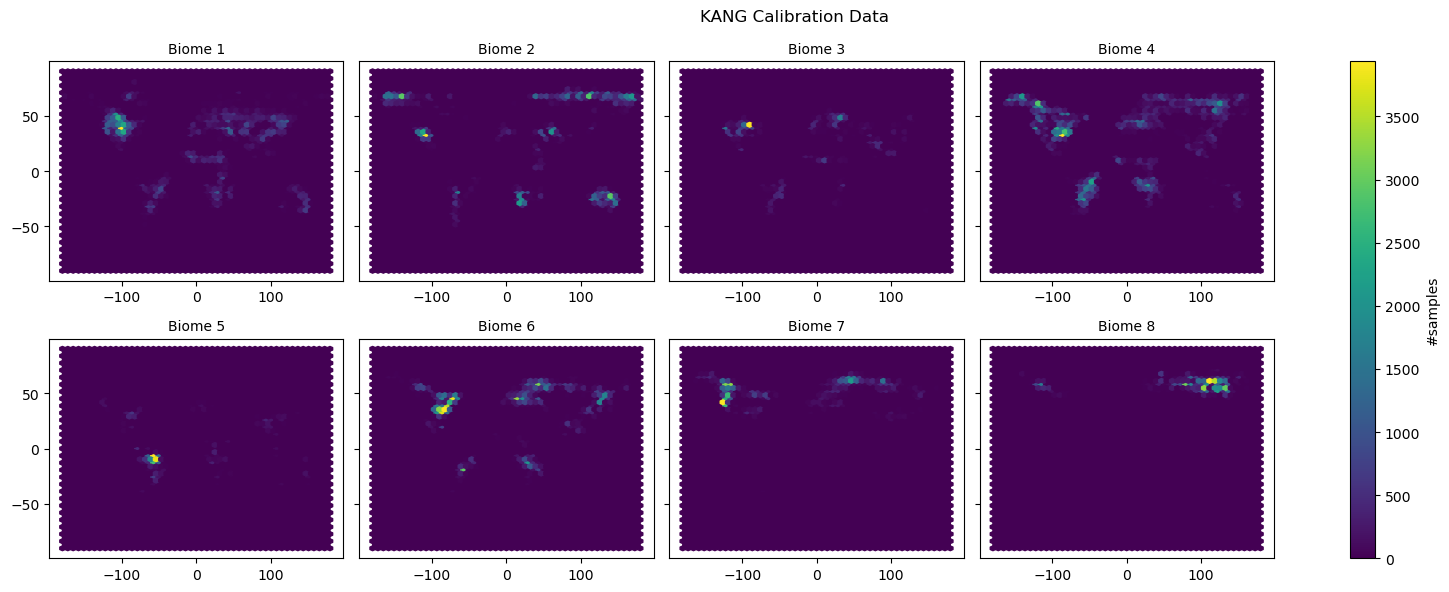

In [7]:
# RF - we will probably not put this in the paper but it is good to see the samples are in the expected area geographically

fig, axes = plt.subplots(2, 4, figsize=(16,6), sharey=True)
cmap=cm.get_cmap('viridis')
im=cm.ScalarMappable()
axes[0][0].hexbin(calbiomeDictLAIKANG[1]['DF']['Lon'], calbiomeDictLAIKANG[1]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][1].hexbin(calbiomeDictLAIKANG[2]['DF']['Lon'], calbiomeDictLAIKANG[2]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][2].hexbin(calbiomeDictLAIKANG[3]['DF']['Lon'], calbiomeDictLAIKANG[3]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][3].hexbin(calbiomeDictLAIKANG[4]['DF']['Lon'], calbiomeDictLAIKANG[4]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

axes[1][0].hexbin(calbiomeDictLAIKANG[5]['DF']['Lon'], calbiomeDictLAIKANG[5]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][1].hexbin(calbiomeDictLAIKANG[6]['DF']['Lon'], calbiomeDictLAIKANG[6]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][2].hexbin(calbiomeDictLAIKANG[7]['DF']['Lon'], calbiomeDictLAIKANG[7]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
hb = axes[1][3].hexbin(calbiomeDictLAIKANG[8]['DF']['Lon'], calbiomeDictLAIKANG[8]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

fig.suptitle('KANG Calibration Data')

# Title biomes
axes[0][0].set_title('Biome 1', size=10)
axes[0][1].set_title('Biome 2', size=10)
axes[0][2].set_title('Biome 3', size=10)
axes[0][3].set_title('Biome 4', size=10)

axes[1][0].set_title('Biome 5', size=10)
axes[1][1].set_title('Biome 6', size=10)
axes[1][2].set_title('Biome 7', size=10)
axes[1][3].set_title('Biome 8', size=10)

fig.tight_layout()

#Add colorbar
cb = fig.colorbar(hb, ax=axes)
cb.set_label('#samples')

plt.show()

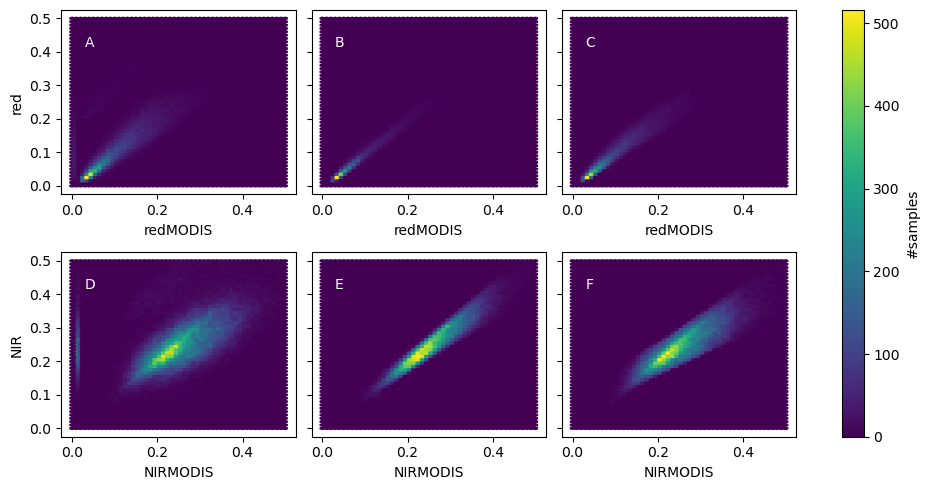

In [8]:
# RF - I have slightly modified this to include regressions
fig, axs = plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(10,5))
dfA = dfALL.sample(100000) / 10000
axs[0,0].hexbin(dfA['redMODIS'],dfA['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[0,0].set(xlabel='redMODIS', ylabel='red')
axs[1,0].hexbin(dfA['NIRMODIS'],dfA['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[1,0].set(xlabel='NIRMODIS', ylabel='NIR')

dfT = dfALLtrim.sample(100000) / 10000
axs[0,1].hexbin(dfT['redMODIS'],dfT['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[0,1].set(xlabel='redMODIS')
hb=axs[1,1].hexbin(dfT['NIRMODIS'],dfT['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[1,1].set(xlabel='NIRMODIS')

dfK = dfALLtrimKANG.sample(100000) / 10000
axs[0,2].hexbin(dfK['redMODIS'],dfK['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[0,2].set(xlabel='redMODIS')
hb=axs[1,2].hexbin(dfK['NIRMODIS'],dfK['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[1,2].set(xlabel='NIRMODIS')

#Add colorbar
fig.tight_layout()
cb = fig.colorbar(hb, ax=axs)
cb.set_label('#samples')

#Add labels
axs[0,0].text(0.1, 0.8, 'A', size=10, color='white', transform=axs[0,0].transAxes)
axs[1,0].text(0.1, 0.8, 'D', size=10, color='white', transform=axs[1,0].transAxes)
axs[0,1].text(0.1, 0.8, 'B', size=10, color='white', transform=axs[0,1].transAxes)
axs[1,1].text(0.1, 0.8, 'E', size=10, color='white', transform=axs[1,1].transAxes)
axs[0,2].text(0.1, 0.8, 'C', size=10, color='white', transform=axs[0,2].transAxes)
axs[1,2].text(0.1, 0.8, 'F', size=10, color='white', transform=axs[1,2].transAxes)

plt.show()

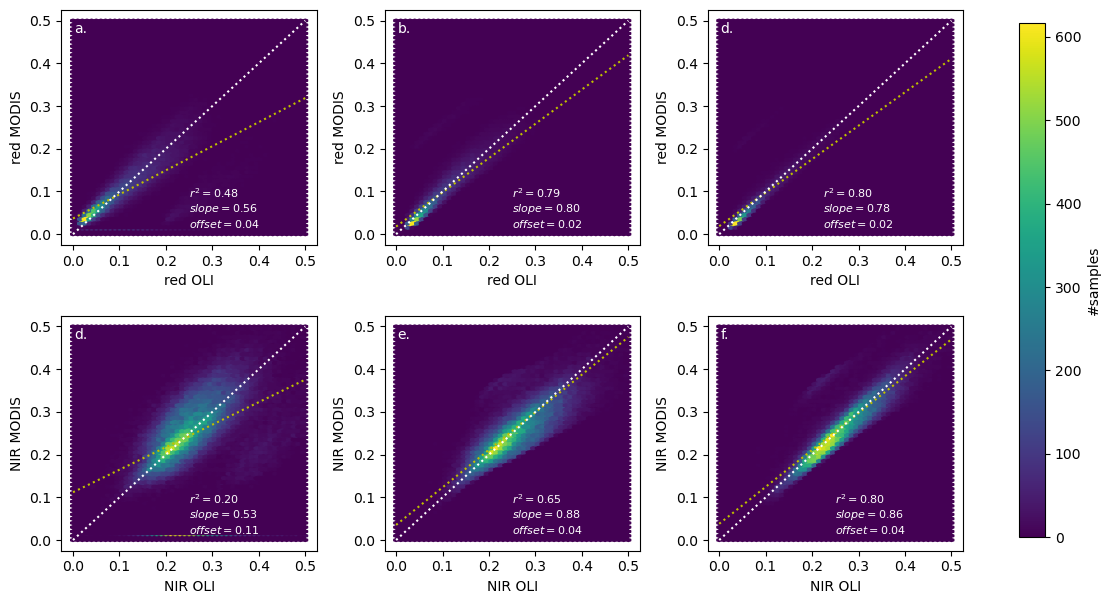

In [11]:
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(12,6))
fig.tight_layout(w_pad=3,h_pad=3)

df = dfALL.sample(100000) / 10000
ax[0,0].hexbin(df['red'],df['redMODIS'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[0,0].set(xlabel='red OLI', ylabel='red MODIS')
r = LinearRegression().fit(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
rscore=r.score(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[0,0].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[0,0].plot([0,0.5],[0,0.5],':w')
ax[0,0].text(0.05, 0.95, 'a.', transform=ax[0,0].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[0,0].text(0.5, 0.25, textstr, transform=ax[0,0].transAxes, fontsize=8,verticalalignment='top',color='w')

ax[1,0].hexbin(df['NIR'],df['NIRMODIS'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[1,0].set(xlabel='NIR OLI', ylabel='NIR MODIS')
from sklearn.linear_model import LinearRegression
r = LinearRegression().fit(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
rscore=r.score(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[1,0].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[1,0].plot([0,0.5],[0,0.5],':w')
ax[1,0].text(0.05, 0.95, 'd.', transform=ax[1,0].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[1,0].text(0.5, 0.25, textstr, transform=ax[1,0].transAxes, fontsize=8,verticalalignment='top',color='w')

df = dfALLtrimKANG.sample(100000) / 10000
ax[0,1].hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[0,1].set(xlabel='red OLI', ylabel='red MODIS')
r = LinearRegression().fit(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
rscore=r.score(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[0,1].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[0,1].plot([0,0.5],[0,0.5],':w')
ax[0,1].text(0.05, 0.95, 'b.', transform=ax[0,1].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[0,1].text(0.5, 0.25, textstr, transform=ax[0,1].transAxes, fontsize=8,verticalalignment='top',color='w')


ax[1,1].hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[1,1].set(xlabel='NIR OLI', ylabel='NIR MODIS')
r = LinearRegression().fit(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
rscore=r.score(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[1,1].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[1,1].plot([0,0.5],[0,0.5],':w')
ax[1,1].text(0.05, 0.95, 'e.', transform=ax[1,1].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[1,1].text(0.5, 0.25, textstr, transform=ax[1,1].transAxes, fontsize=8,verticalalignment='top',color='w')


df = dfALLtrim.sample(100000) / 10000
ax[0,2].hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[0,2].set(xlabel='red OLI', ylabel='red MODIS')
r = LinearRegression().fit(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
rscore=r.score(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[0,2].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[0,2].plot([0,0.5],[0,0.5],':w')
ax[0,2].text(0.05, 0.95, 'd.', transform=ax[0,2].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[0,2].text(0.45, 0.25, textstr, transform=ax[0,2].transAxes, fontsize=8,verticalalignment='top',color='w')


im=ax[1,2].hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[1,2].set(xlabel='NIR OLI', ylabel='NIR MODIS')
r = LinearRegression().fit(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
rscore=r.score(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[1,2].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[1,2].plot([0,0.5],[0,0.5],':w')
ax[1,2].text(0.05, 0.95, 'f.', transform=ax[1,2].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[1,2].text(0.5, 0.25, textstr, transform=ax[1,2].transAxes, fontsize=8,verticalalignment='top',color='w')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('#samples')

plt.savefig('Figure2.png', bbox_inches='tight')

plt.show()


Pairplots of sampled respose values by biome

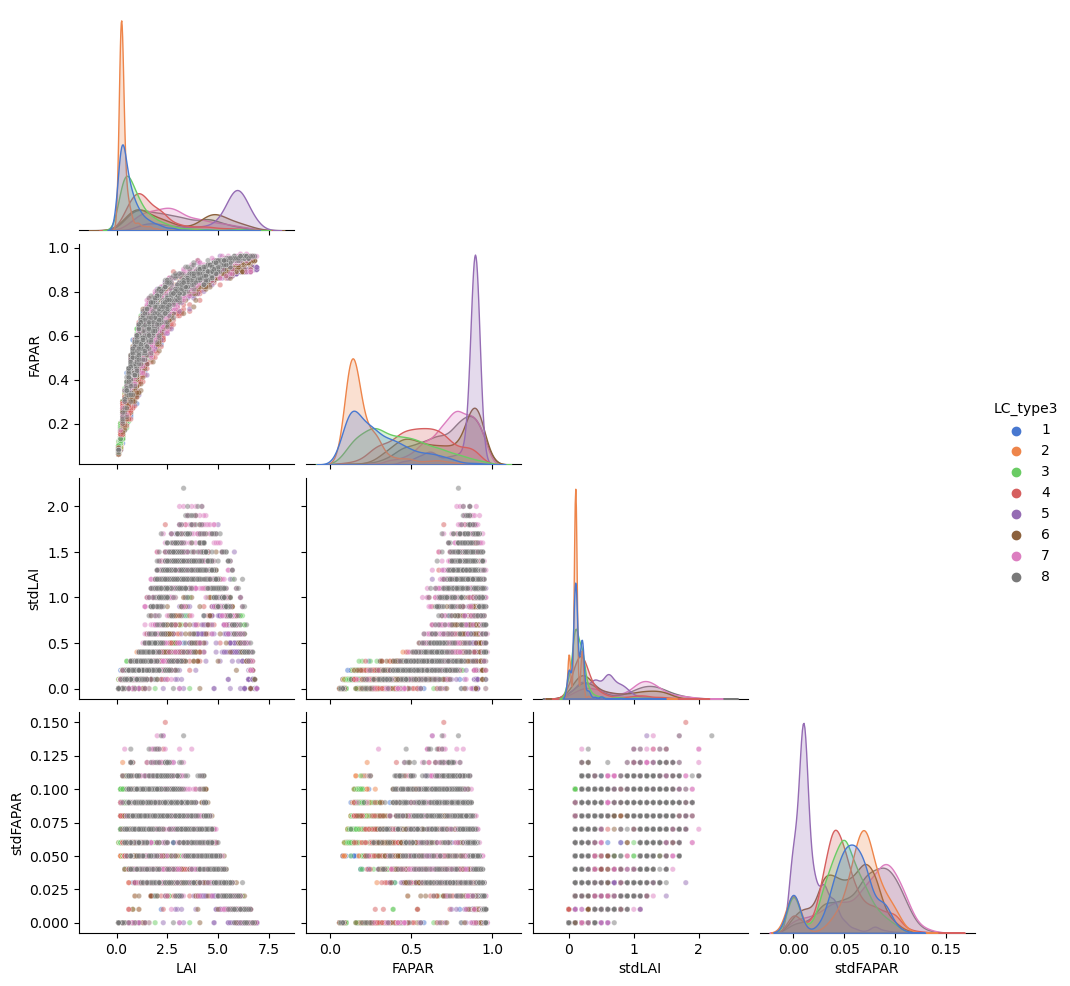

In [9]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 100.,10.,100.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3'])
dfPlot = dfALL.loc[dfALL['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3']].groupby('LC_type3').sample(1000).div(dfScaling.iloc[0])
dfPlot['LC_type3'] = dfPlot['LC_type3'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LC_type3',palette='muted',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure2.png", bbox_inches='tight') 

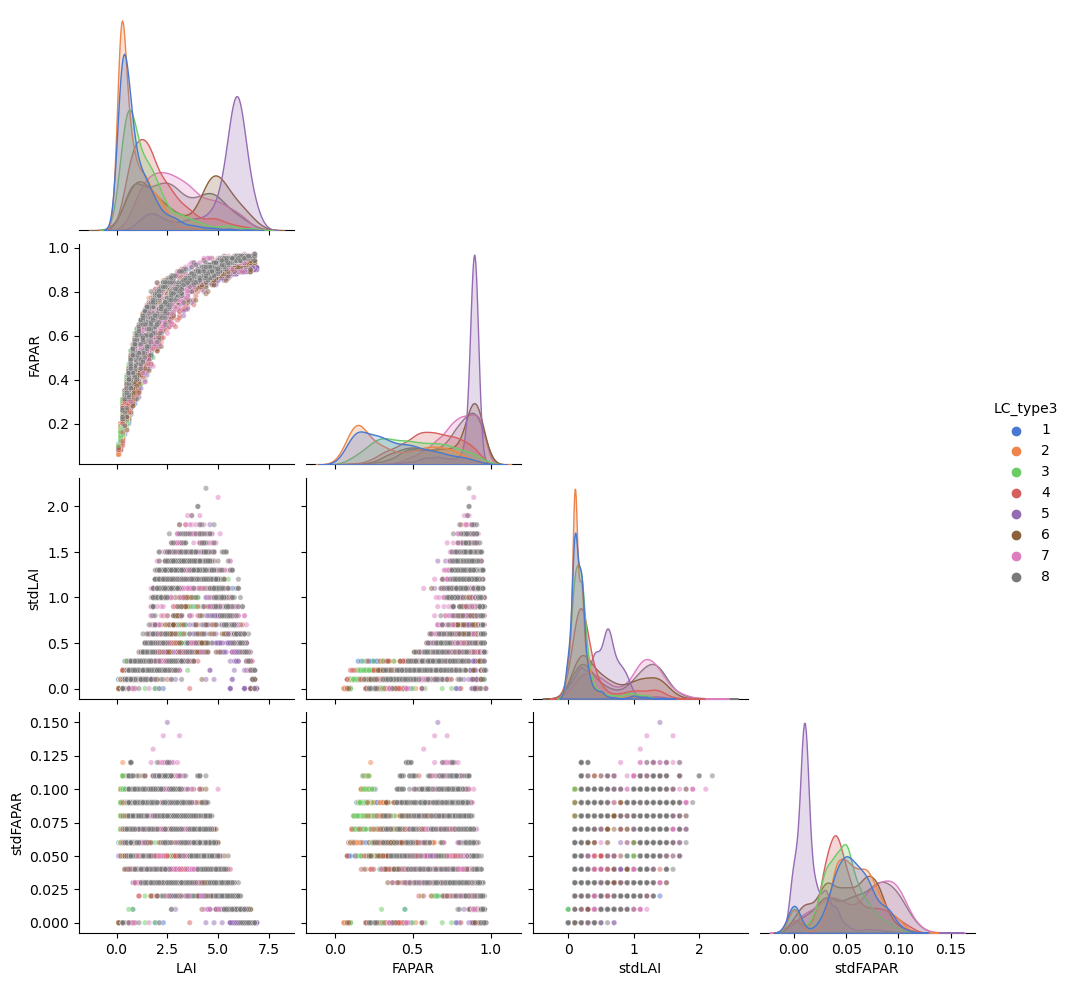

In [10]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 100.,10.,100.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3'])
dfPlot = dfALLtrim.loc[dfALLtrim['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3']].groupby('LC_type3').sample(1000).div(dfScaling.iloc[0])
dfPlot['LC_type3'] = dfPlot['LC_type3'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LC_type3',palette='muted',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure2.png", bbox_inches='tight') 

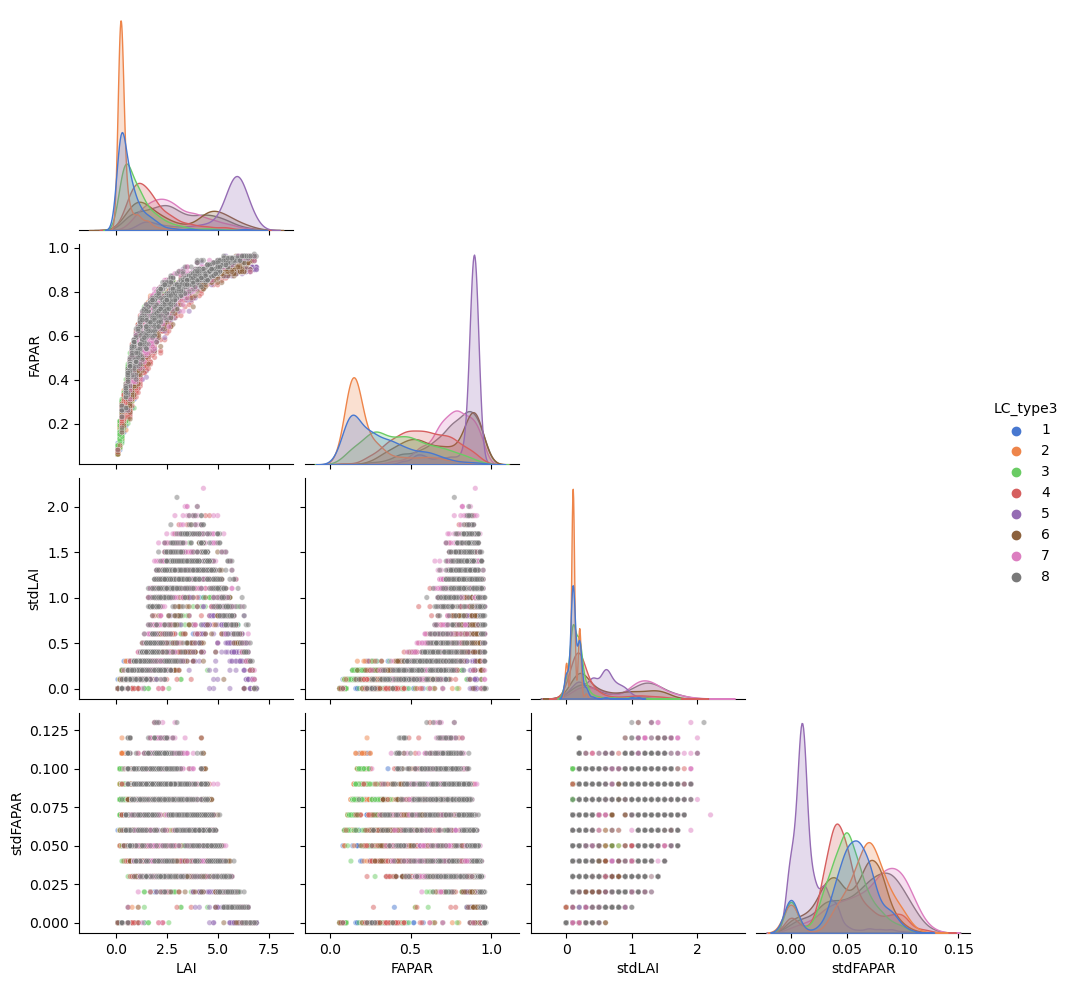

In [11]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 100.,10.,100.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3'])
dfPlot = dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3']].groupby('LC_type3').sample(1000).div(dfScaling.iloc[0])
dfPlot['LC_type3'] = dfPlot['LC_type3'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LC_type3',palette='muted',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure2.png", bbox_inches='tight') 

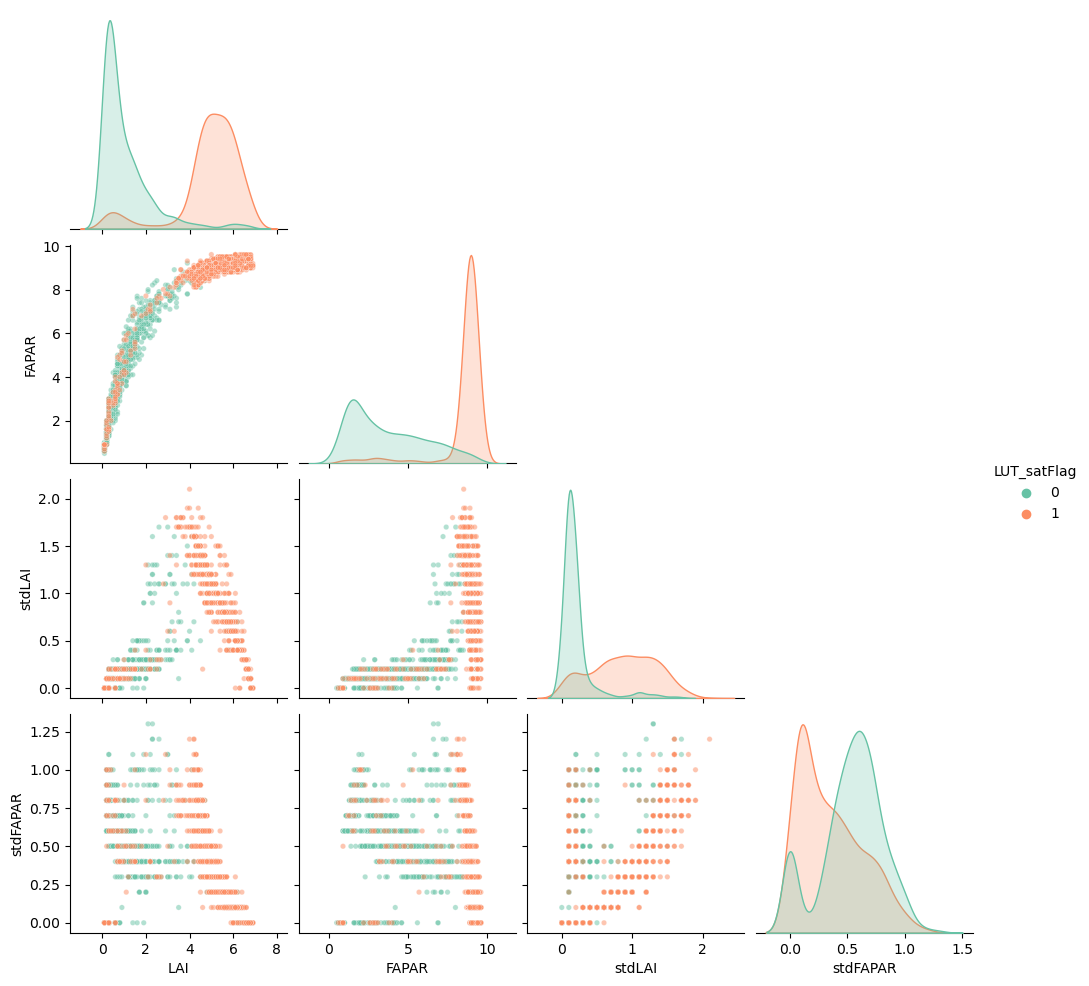

In [12]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 10.,10.,10.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag'])
dfPlot = dfALL.loc[dfALL['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag']].groupby('LUT_satFlag').sample(1000).div(dfScaling.iloc[0])
dfPlot['LUT_satFlag'] = dfPlot['LUT_satFlag'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LUT_satFlag',palette='Set2',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure3.png", bbox_inches='tight') 

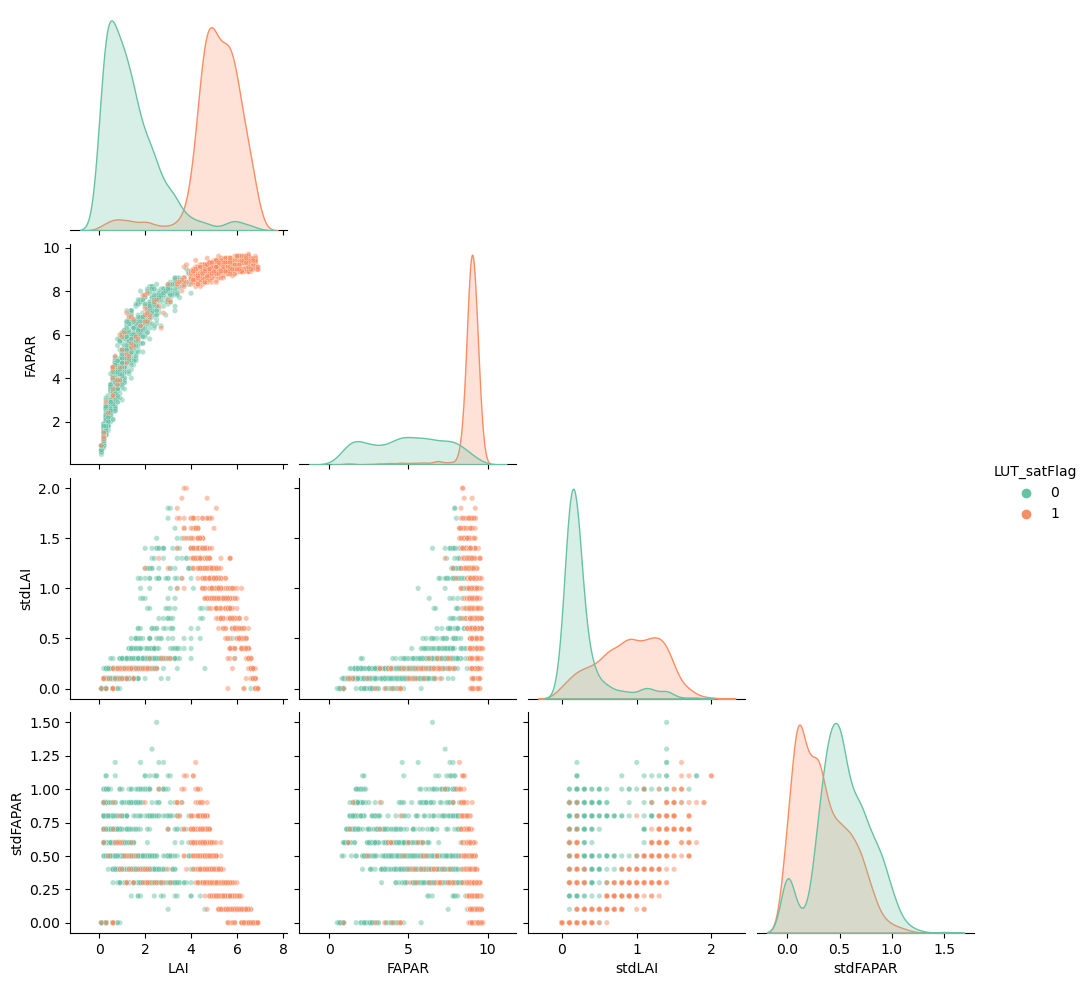

In [13]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 10.,10.,10.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag'])
dfPlot = dfALLtrim.loc[dfALLtrim['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag']].groupby('LUT_satFlag').sample(1000).div(dfScaling.iloc[0])
dfPlot['LUT_satFlag'] = dfPlot['LUT_satFlag'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LUT_satFlag',palette='Set2',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure3.png", bbox_inches='tight') 

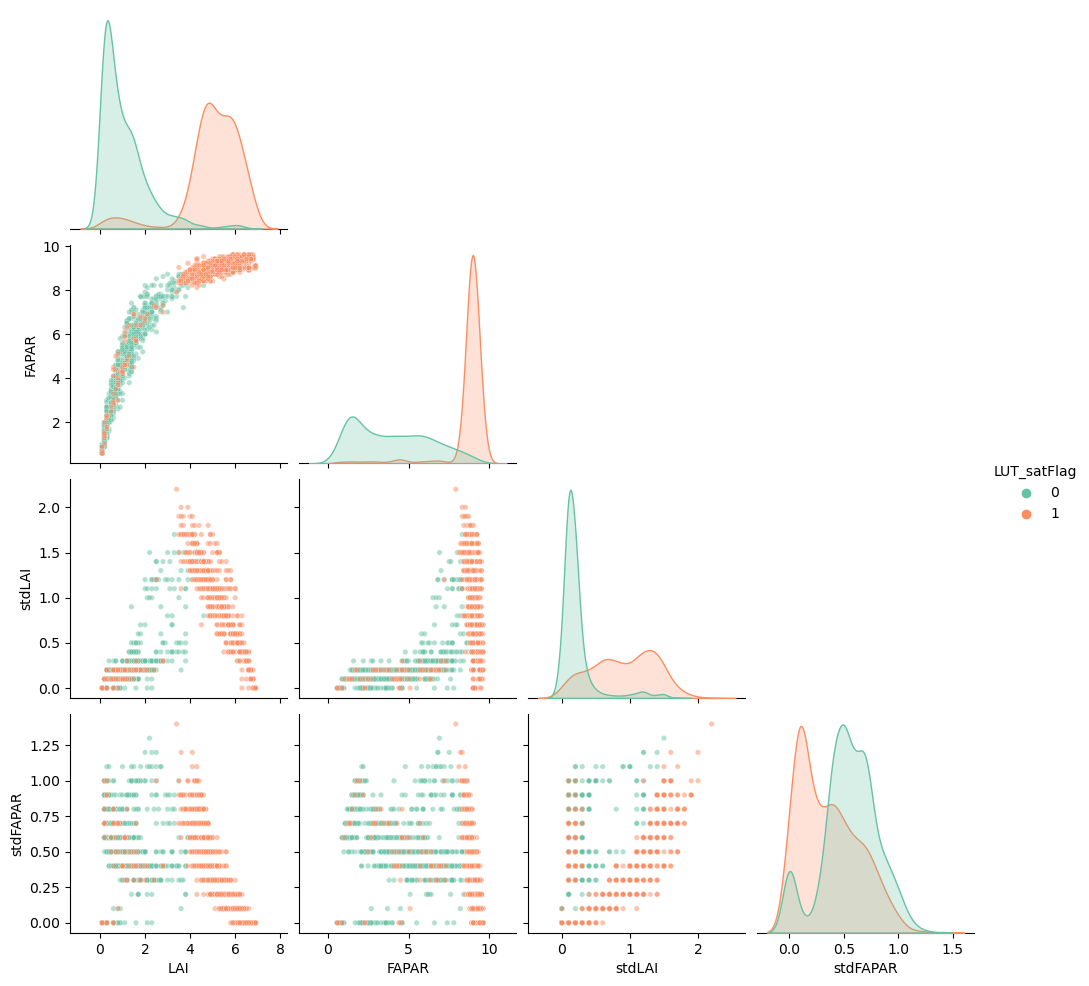

In [14]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 10.,10.,10.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag'])
dfPlot = dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag']].groupby('LUT_satFlag').sample(1000).div(dfScaling.iloc[0])
dfPlot['LUT_satFlag'] = dfPlot['LUT_satFlag'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LUT_satFlag',palette='Set2',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure3.png", bbox_inches='tight') 

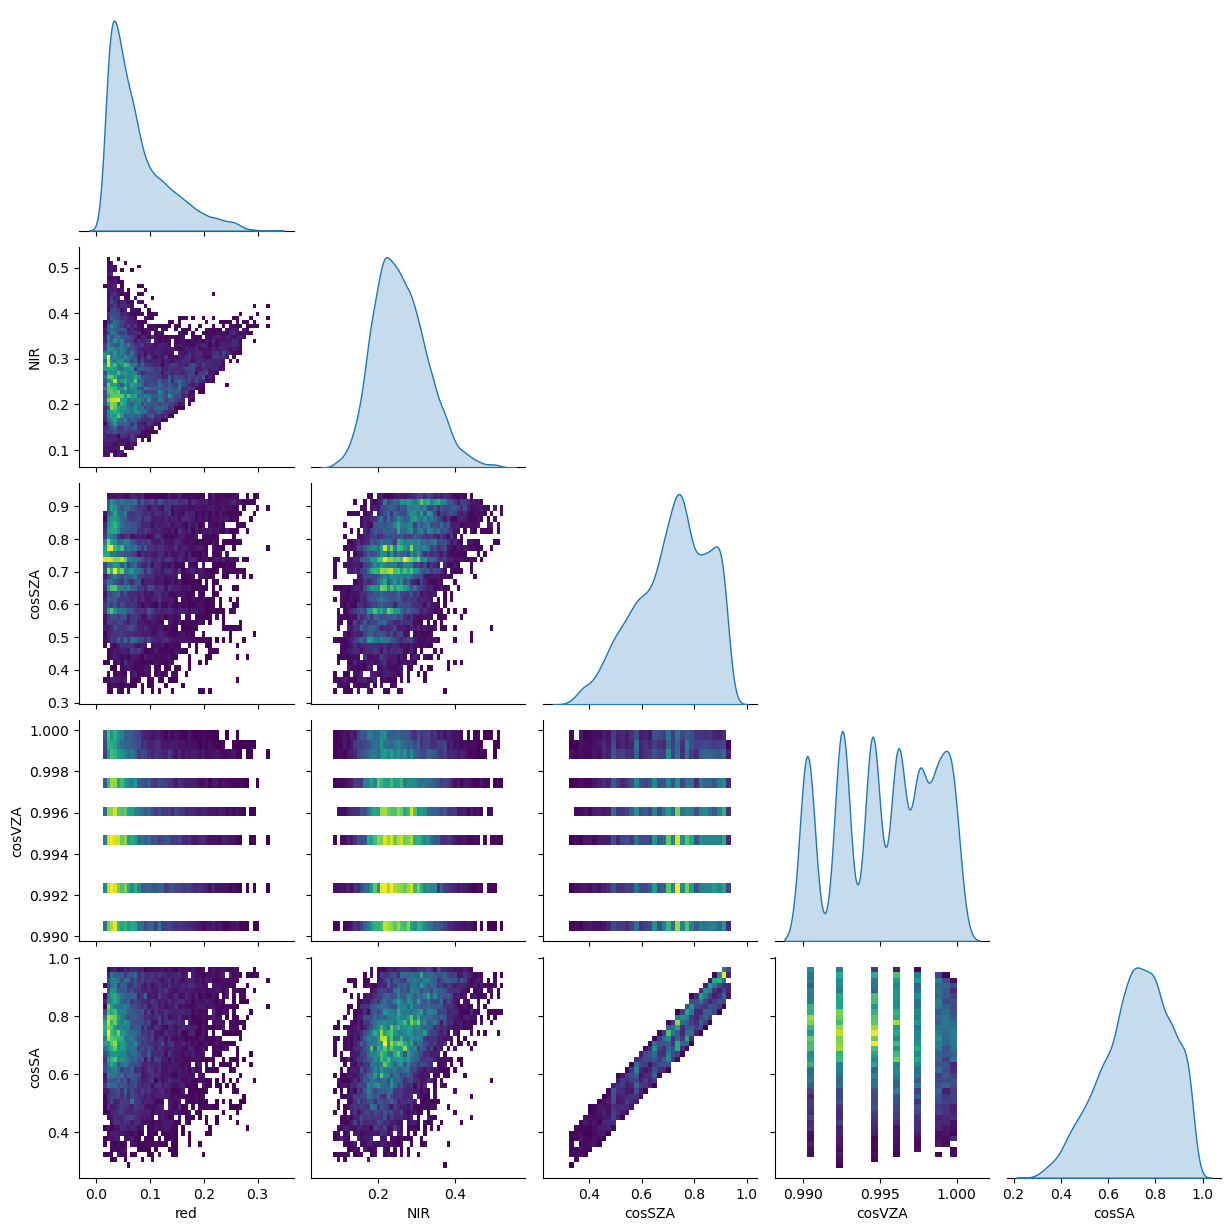

In [15]:
#RF - we will not use this
pairplot = sns.pairplot(dfALLtrim.loc[dfALLtrim['LC_type3']<9][['red','NIR','cosSZA','cosVZA','cosSA']].sample(10000).divide(10000),plot_kws={'cmap':'viridis'},kind='hist',diag_kind='kde',corner=True)
#pairplot.fig.savefig("Figure4.png", bbox_inches='tight') 

Graphs for dfALL

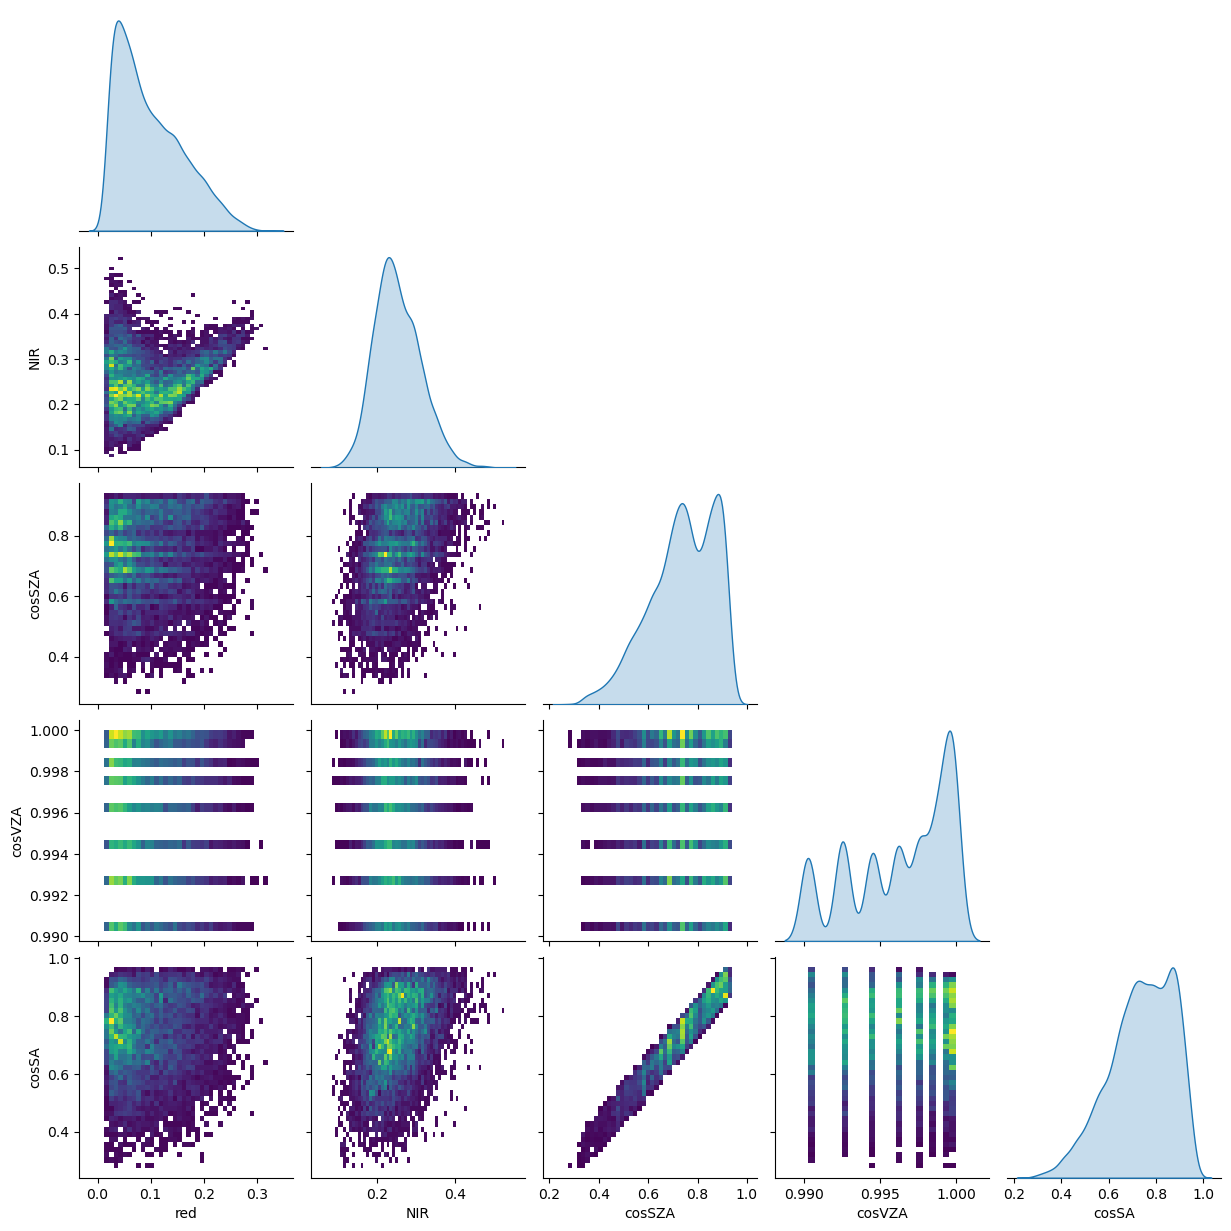

In [16]:
#RF - we will not use this
pairplot = sns.pairplot(dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']<9][['red','NIR','cosSZA','cosVZA','cosSA']].sample(10000).divide(10000),plot_kws={'cmap':'viridis'},kind='hist',diag_kind='kde',corner=True)
#pairplot.fig.savefig("Figure4.png", bbox_inches='tight')

Reading in calibration and validation data.

In [ ]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictFAPAR.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAI.pkl')
calbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPAR.pkl')

# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANG.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANG.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

In [ ]:
# RF - Cassidy please make separate plots like Fig 7 of K2021 for LAI and fAPAR from calbiomeDictLAIKANG and calbiomeDictFAPARKANG BUT with one change
#       Add a second series of histograms on the plot corresponding to the NAIVE database from calbiomeDictLAI and calbiomeDictFAPAR using only kde (it will show lines) and no boxes


In [ ]:
NAIVE LAI
method='NAIVE'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAI.keys():
    df = calbiomeDictLAI[LC_type3]['DF']
    calbiomeDictLAI[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAI[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAI[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAI[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])
    valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[0,70]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[-25,25]],nbins=70,gamma=0.5)

In [ ]:
#NAIVE FAPAR
method='NAIVE'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'FAPAR'
valbiomeDFFAPAR = pd.DataFrame()
for LC_type3 in calbiomeDictFAPAR.keys():
    df = calbiomeDictFAPAR[LC_type3]['DF']
    calbiomeDictFAPAR[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPAR[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3][method+response+'regression'] = calbiomeDictFAPAR[LC_type3][method+response+'regression']
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPAR[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])
    valbiomeDFFAPAR = pd.concat([valbiomeDFFAPAR,valbiomeDictFAPAR[LC_type3]['DF']])
sns.scatterplot(valbiomeDFFAPAR.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[0,100]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[-25,25]],nbins=70,gamma=0.5)


In [ ]:
#K2021 LAI
method='KANG'
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAIKANG.keys():
    df = calbiomeDictLAIKANG[LC_type3]['DF']
    calbiomeDictLAIKANG[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=50,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAIKANG[LC_type3]['DF'][method+response] = calbiomeDictLAIKANG[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAIKANG[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAIKANG[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])
    valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[0,70]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[-25,25]],nbins=70,gamma=0.5)

In [ ]:
# K2021 FAPAR
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
response = 'FAPAR'
valbiomeDFFAPAR = pd.DataFrame()
for LC_type3 in calbiomeDictFAPARKANG.keys():
    df = calbiomeDictFAPARKANG[LC_type3]['DF']
    calbiomeDictFAPARKANG[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=50,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictFAPARKANG[LC_type3]['DF'][method+response] = calbiomeDictFAPARKANGKANG[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3][method+response+'regression'] = calbiomeDictFAPARKANG[LC_type3][method+response+'regression']
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARKANG[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])
    valbiomeDFFAPAR = pd.concat([valbiomeDFFAPAR,valbiomeDictFAPAR[LC_type3]['DF']])
sns.scatterplot(valbiomeDFFAPAR.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[0,100]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[-25,25]],nbins=70,gamma=0.5)

In [ ]:
# FTL LAI
method = 'FTL'

# response variable name
response = ['LAI']

# Regressor Names
# Names within scope of this script
regressorsNames = ['red','NIR','cosSZA','cosVZA','cosSA']
samplingFeatures = regressorsNames
# Names within scope of GEE
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 
# Generic names we export RF with
regressors = ["x1","x2","x3","x4","x5"]

#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]

calbiomeDictLAIFTL= hierarchicalRF(calbiomeDictLAIFTL,calbiomeDictLAI,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
                             maxleafnodesParent=999 ,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 100)
calbiomeDictLAIFTL=  predictClassifier(calbiomeDictLAIFTL,calbiomeDictLAIFTL, 'FTL', regressorsNames, ['LAI'])
valbiomeDictLAI=  predictClassifier(valbiomeDictLAI,calbiomeDictLAIFTL, 'FTL', regressorsNames, ['LAI'])


method = 'FTL'
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAI.keys():
    if ( LC_type3<10) :
        valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),x=response,y=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFLAI,method+response,'LAI',datarange=[[0,80],[0,80]],nbins=80,gamma=0.5)
plotHistResidualsCond(valbiomeDFLAI,method+response,'LAI',datarange=[[0,80],[-25,25]],nbins=80,gamma=0.5)

In [ ]:
# FTL FAPAR
method = 'FTL'

# response variable name
response = ['FAPAR']

# Regressor Names
# Names within scope of this script
regressorsNames = ['red','NIR','cosSZA','cosVZA','cosSA']
samplingFeatures = regressorsNames
# Names within scope of GEE
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 
# Generic names we export RF with
regressors = ["x1","x2","x3","x4","x5"]

#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]

calbiomeDictFAPARFTL= hierarchicalRF(calbiomeDictFAPARFTL,calbiomeDictLAI,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
                             maxleafnodesParent=999 ,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 100)


calbiomeDictFAPARFTL=  predictClassifier(calbiomeDictFAPARFTL,calbiomeDictFAPARFTL, 'FTL', regressorsNames, ['FAPAR'])
valbiomeDictFAPAR=  predictClassifier(valbiomeDictLAI,calbiomeDictFAPARFTL, 'FTL', regressorsNames, ['FAPAR'])


method = 'FTL'
response = 'FAPAR'
valbiomeDFFAPAR = pd.DataFrame()
for LC_type3 in calbiomeDictFAPAR.keys():
    if ( LC_type3<10) :
        valbiomeDFFAPAR = pd.concat([valbiomeDFFAPAR,valbiomeDictFAPAR[LC_type3]['DF']])
sns.scatterplot(valbiomeDFFAPAR.sample(10000),x=response,y=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFFAPAR,method+response,'FAPAR',datarange=[[0,80],[0,80]],nbins=80,gamma=0.5)
plotHistResidualsCond(valbiomeDFFAPAR,method+response,'FAPAR',datarange=[[0,80],[-25,25]],nbins=80,gamma=0.5)

In [ ]:
# Cassidy - please make plots like fig 8 of K2021 but in stead of all and correctly classified series you will need a separate series for each method
# Once you make the plots for LAI repeat for FAPAR

In [ ]:
# ee.Authenticate()

In [ ]:
# ee.Initialize()

In [ ]:
# upload FTL classiers to gee as feature collections
# reload(mlLocal)

# method = 'FTl'

# # response variable name
# response = ['LAI']

# # Scalnig and offset required of GEE regressors
# regressorsGEECollectionName= "LANDSAT/LC08/C02/T1_L2"
# regressorsGEEScaling = [2.75e-05,2.75e-05,1,1,1]
# regressorsGEEOffset = [-0.02,-0.02,0,0,0]
# regressorsGEEScaling2 = [10000,10000,1,1,1]


# for biome in dfALL4['LC_type3'].unique():
#     print(biome)
#     if ( biome==8) :
#         parentRFDict = naive2Dict[biome][method+response[0]+'parentRFDict']
#         domain = parentRFDict['domain']
#         trees = []
#         trees.append(make_tree(parentRFDict['RF'][0],regressors,3))
#         # print(trees[0])
#         print(len(parentRFDict['childrenRFDict']))
#         assetID = geemap.ee_user_id() + '/modisLandsatTrees/' + method + 'biome' + str(biome) + 'parentRF' 
#         mlLocal.export_trees_to_fc_CCRS(trees,response,regressors,regressorsGEECollectionName,regressorsGEENames,regressorsGEEScaling2,regressorsGEEScaling,regressorsGEEOffset,domain,domainScaling,domainOffset,assetID)
#         #ml.export_trees_to_fc(trees,assetID)
#         # ee_classifier = ml.strings_to_classifier(trees)
#         # print(ee_classifier.getInfo())

#         childSize = []
#         for partition in parentRFDict['childrenRFDict'].keys():
#             # print(partition)
#             childRFDict = parentRFDict['childrenRFDict'][partition]
#             childSize.append(childRFDict['size'])

#             trees = []
#             for tree in np.squeeze(childRFDict['RF'].estimators_) :
#                 trees.append(make_tree(tree,regressors,3))
#             # print(trees)
#             # trees = ml.rf_to_strings(estimator=childRFDict['RF'], feature_names=regressors,processes=36,output_mode='REGRESSION')
#             assetID = geemap.ee_user_id() + '/modisLandsatTrees/' + method + 'biome' + str(biome) + 'childRF' + str(int(partition*1000)) 
#             domain = [0]
#             domainScaling = [0]
#             domainOffset = [0]
#             mlLocal.export_trees_to_fc_CCRS(trees,response,regressors,regressorsGEECollectionName,regressorsGEENames,regressorsGEEScaling2,regressorsGEEScaling,regressorsGEEOffset,domain,domainScaling,domainOffset,assetID)
#             # ml.export_trees_to_fc(trees,assetID)
#             # ee_classifier = ml.strings_to_classifier(trees)
#             # print(ee_classifier.getInfo())
#         print(childSize)